# Guardian API Exploration

This notebook explores the Guardian API to understand:
- What data is available
- Quality of tech news content
- Best search terms and filters
- Data structure and fields

## Setup


In [17]:
import sys
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import List, Dict, Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv('../../.env')  # Load from project root

# Check if .env file exists
if not os.path.exists('../../.env'):
    print("❌ No .env file found!")
    print("📝 Please create a .env file with your Guardian API key:")
    print("   GUARDIAN_API_KEY=your_api_key_here")
    print("\n💡 You can copy env.example to .env and add your key")
    print("   cp ../../env.example ../../.env")
else:
    print("✅ .env file found")

class GuardianCollector:
    def __init__(self):
        # Try to load from .env file if not already loaded
        if not os.getenv('GUARDIAN_API_KEY'):
            load_dotenv()
        
        self.api_key = os.getenv('GUARDIAN_API_KEY')
        self.base_url = 'https://content.guardianapis.com/search'
        
        if not self.api_key:
            raise ValueError("GUARDIAN_API_KEY not found in environment variables")
    
    def fetch_articles(self, 
                      query: str = "technology",
                      section: str = "technology",
                      days_back: int = 1,
                      page_size: int = 20,
                      order_by: str = "newest") -> List[Dict]:
        """
        Fetch articles from Guardian API
        
        Args:
            query: Search terms (e.g., "artificial intelligence", "startup")
            section: Section to search (technology, business, science)
            days_back: How many days back to search
            page_size: Number of articles to fetch (max 50)
            order_by: Sort by newest, oldest, or relevance
        
        Returns:
            List of article dictionaries
        """
        # Calculate date range
        to_date = datetime.now()
        from_date = to_date - timedelta(days=days_back)
        
        params = {
            'q': query,
            'section': section,
            'from-date': from_date.strftime('%Y-%m-%d'),
            'to-date': to_date.strftime('%Y-%m-%d'),
            'order-by': order_by,
            'page-size': min(page_size, 50),  # API limit is 50
            'show-fields': 'all',
            'api-key': self.api_key
        }
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            
            data = response.json()
            articles = data.get('response', {}).get('results', [])
            
            # Clean and structure the data
            cleaned_articles = []
            for article in articles:
                cleaned_article = {
                    'title': article.get('webTitle', ''),
                    'url': article.get('webUrl', ''),
                    'section': article.get('sectionName', ''),
                    'published': article.get('webPublicationDate', ''),
                    'summary': article.get('fields', {}).get('trailText', ''),
                    'content': article.get('fields', {}).get('body', ''),
                    'thumbnail': article.get('fields', {}).get('thumbnail', ''),
                    'tags': [tag.get('webTitle', '') for tag in article.get('tags', [])]
                }
                cleaned_articles.append(cleaned_article)
            
            return cleaned_articles
            
        except requests.exceptions.RequestException as e:
            print(f"Error fetching articles: {e}")
            return []
    
    def get_tech_news(self, days_back: int = 1) -> List[Dict]:
        """Get general tech news"""
        return self.fetch_articles(
            query="technology",
            section="technology",
            days_back=days_back
        )
    
    def get_ai_news(self, days_back: int = 1) -> List[Dict]:
        """Get AI-related news"""
        return self.fetch_articles(
            query="artificial intelligence OR machine learning OR AI",
            section="technology",
            days_back=days_back
        )
    
    def get_startup_news(self, days_back: int = 1) -> List[Dict]:
        """Get startup and business tech news"""
        return self.fetch_articles(
            query="startup OR venture capital OR funding",
            section="business",
            days_back=days_back
        )
    
    def get_science_tech(self, days_back: int = 1) -> List[Dict]:
        """Get science and research tech news"""
        return self.fetch_articles(
            query="technology",
            section="science",
            days_back=days_back
        )



✅ .env file found


## Test API Connection


In [18]:
# Test basic connection
try:
    collector = GuardianCollector()
    print(f"API Key loaded: {'✅' if collector.api_key else '❌'}")
    print("✅ API key found, ready to fetch data!")
except ValueError as e:
    print(f"❌ Error: {e}")
    print("\n📝 To fix this:")
    print("1. Copy the example file: cp ../../env.example ../../.env")
    print("2. Edit ../../.env and add your Guardian API key")
    print("3. Restart this notebook")
    print("\n💡 Get your API key from: https://open-platform.theguardian.com/")


API Key loaded: ✅
✅ API key found, ready to fetch data!


## Fetch Sample Data


In [19]:
# Fetch tech news from today
print("📰 Fetching tech news from today...")
articles = collector.get_tech_news(days_back=1)

if articles:
    print(f"✅ Successfully fetched {len(articles)} articles")
    print("\n📋 Sample articles:")
    for i, article in enumerate(articles[:3], 1):
        print(f"{i}. {article['title']}")
        print(f"   Published: {article['published']}")
        print(f"   Section: {article['section']}")
        print(f"   URL: {article['url']}")
        print()
else:
    print("❌ No articles found")


📰 Fetching tech news from today...
✅ Successfully fetched 3 articles

📋 Sample articles:
1. What is new in UK-US tech deal and what will it mean for the British economy?
   Published: 2025-09-17T14:29:18Z
   Section: Technology
   URL: https://www.theguardian.com/technology/2025/sep/17/what-is-new-uk-us-tech-deal-ai-supercomputers-investment-economy

2. ChatGPT developing age-verification system to identify under-18 users after teen death
   Published: 2025-09-17T06:05:06Z
   Section: Technology
   URL: https://www.theguardian.com/technology/2025/sep/17/chatgpt-developing-age-verification-system-to-identify-under-18-users-after-teen-death

3. ‘I love you too!’ My family’s creepy, unsettling week with an AI toy
   Published: 2025-09-16T04:00:27Z
   Section: Technology
   URL: https://www.theguardian.com/technology/2025/sep/16/i-love-you-too-my-familys-creepy-unsettling-week-with-an-ai-toy



## Save Data for Future Processing


In [20]:
# Save articles to JSON for future processing
if articles:
    df = pd.DataFrame(articles)
    
    # Create guardian data directory if it doesn't exist
    os.makedirs('../data/guardian', exist_ok=True)
    
    # Save to JSON (better for complex data structures)
    json_path = '../data/guardian/guardian_articles.json'
    df.to_json(json_path, orient='records', indent=2)
    print(f"💾 Saved {len(df)} articles to {json_path}")
    
    # Display basic info
    print(f"\n📊 Data Summary:")
    print(f"   Total articles: {len(df)}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Date range: {df['published'].min()} to {df['published'].max()}")
else:
    print("❌ No data to save")


💾 Saved 3 articles to ../data/guardian/guardian_articles.json

📊 Data Summary:
   Total articles: 3
   Columns: ['title', 'url', 'section', 'published', 'summary', 'content', 'thumbnail', 'tags']
   Date range: 2025-09-16T04:00:27Z to 2025-09-17T14:29:18Z


## Explore Different News Categories


In [21]:
# Test different categories
categories = {
    'General Tech': collector.get_tech_news(days_back=1),
    'AI News': collector.get_ai_news(days_back=1),
    'Startup News': collector.get_startup_news(days_back=1),
    'Science Tech': collector.get_science_tech(days_back=1)
}

print("📊 Category Analysis:")
for category, articles in categories.items():
    print(f"{category}: {len(articles)} articles")
    
    # Save each category separately as JSON
    if articles:
        df_cat = pd.DataFrame(articles)
        filename = f"../data/guardian/guardian_{category.lower().replace(' ', '_')}.json"
        df_cat.to_json(filename, orient='records', indent=2)
        print(f"   💾 Saved to {filename}")

# Create summary
category_summary = pd.DataFrame([
    {'Category': cat, 'Article_Count': len(arts)} 
    for cat, arts in categories.items()
])
print(f"\n📈 Category Summary:")
print(category_summary)


📊 Category Analysis:
General Tech: 3 articles
   💾 Saved to ../data/guardian/guardian_general_tech.json
AI News: 8 articles
   💾 Saved to ../data/guardian/guardian_ai_news.json
Startup News: 2 articles
   💾 Saved to ../data/guardian/guardian_startup_news.json
Science Tech: 1 articles
   💾 Saved to ../data/guardian/guardian_science_tech.json

📈 Category Summary:
       Category  Article_Count
0  General Tech              3
1       AI News              8
2  Startup News              2
3  Science Tech              1


## Visualize Category Distribution


💾 Saved plot to ../data/guardian/category_distribution.png


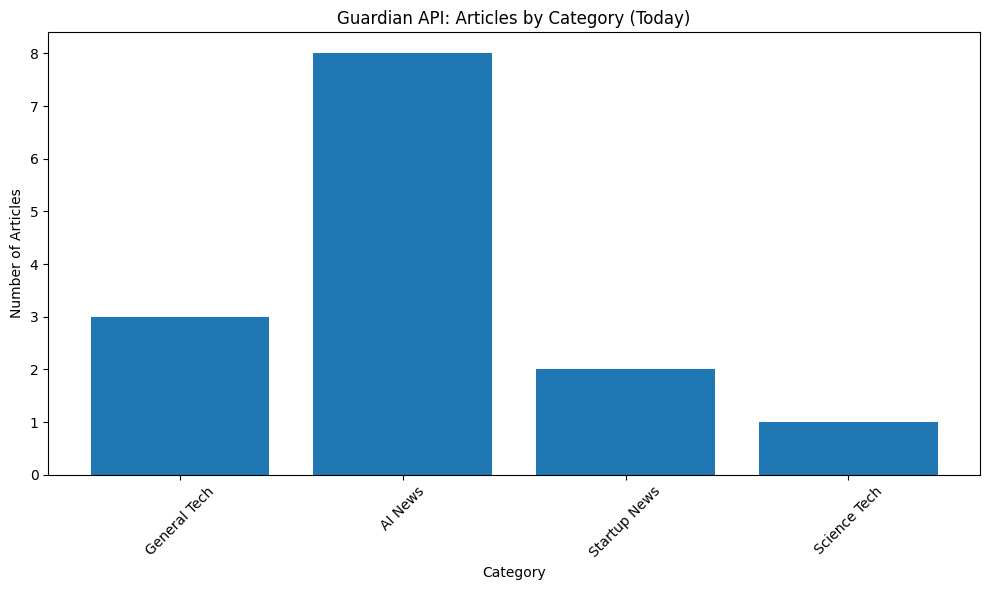

In [22]:
# Create visualization
plt.figure(figsize=(10, 6))
plt.bar(category_summary['Category'], category_summary['Article_Count'])
plt.title('Guardian API: Articles by Category (Today)')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot to guardian folder BEFORE showing it
plt.savefig('../data/guardian/category_distribution.png', dpi=300, bbox_inches='tight')
print("💾 Saved plot to ../data/guardian/category_distribution.png")

# Show the plot
plt.show()


## Save Summary and Metadata


In [23]:
# Create summary metadata
summary_data = {
    'collection_date': datetime.now().isoformat(),
    'total_articles': sum(len(articles) for articles in categories.values()),
    'categories': {
        category: {
            'article_count': len(articles),
            'filename': f"guardian_{category.lower().replace(' ', '_')}.json"
        }
        for category, articles in categories.items()
    },
    'data_structure': {
        'fields': ['title', 'url', 'section', 'published', 'summary', 'content', 'thumbnail', 'tags'],
        'format': 'JSON',
        'encoding': 'UTF-8'
    },
    'api_info': {
        'source': 'Guardian API',
        'endpoint': 'https://content.guardianapis.com/search',
        'rate_limit': '5000 requests/day',
        'collection_period': '1 day'
    }
}

# Save summary metadata
import json
summary_path = '../data/guardian/collection_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary_data, f, indent=2)

print(f"💾 Saved collection summary to {summary_path}")
print(f"\n📊 Collection Summary:")
print(f"   Total articles collected: {summary_data['total_articles']}")
print(f"   Categories: {list(summary_data['categories'].keys())}")
print(f"   Collection date: {summary_data['collection_date']}")


💾 Saved collection summary to ../data/guardian/collection_summary.json

📊 Collection Summary:
   Total articles collected: 14
   Categories: ['General Tech', 'AI News', 'Startup News', 'Science Tech']
   Collection date: 2025-09-17T16:57:28.763831
